In [40]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

In [41]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [117]:
df_dev = load_dataset("csv", data_files="subtaskB_clean_dev_cased.csv")#, column_names=['text', 'label'])#, features=features)
df_test = load_dataset("csv", data_files="subtaskB_clean_test_cased.csv")#, column_names=['text', 'label'])#, features=features)

In [118]:
df_dev['train']

Dataset({
    features: ['comment_text', 'topic'],
    num_rows: 810
})

In [119]:
df_dev = df_dev.rename_column("comment_text", "text")
df_dev = df_dev.rename_column("topic", "label")
df_test = df_test.rename_column("comment_text", "text")

In [120]:
class_names = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']

In [121]:
label = ClassLabel(num_classes=4, names=class_names)
#features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=4, names=class_names)})

In [122]:
df_dev = df_dev.cast_column("label", label)

Casting the dataset:   0%|          | 0/810 [00:00<?, ? examples/s]

In [123]:
df_dev

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 810
    })
})

In [125]:
np.unique(df_dev['train']['label'], return_counts=True)

(array([0, 1, 2, 3]), array([435, 242,  57,  76]))

# Data partioning

In [126]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42, stratify_by_column='label')
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 243
    })
})

In [127]:
df_train = train_val["train"]
df_val = train_val["test"]

In [128]:
df_val

Dataset({
    features: ['text', 'label'],
    num_rows: 243
})

In [130]:
np.unique(df_val['label'], return_counts=True)

(array([0, 1, 2, 3]), array([130,  73,  17,  23]))

# Model loading

In [170]:
nome = 'bert_base'
model_name = 'bert-base-multilingual-cased'

In [163]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [164]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [165]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [166]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 567
})

In [167]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [168]:
def hyperparameter_search(model_name=model_name, optim='adamw_hf', learning_rate=0.00005, dropout=0.1):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned",
            evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=10,
            load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )
    config = AutoConfig.from_pretrained(model_name)
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, num_labels=4)
    return training_args, model

Provare:

Optimizer: SGD, Adagrad,

Learning rate: 0.00005, ...

Dropout: 0.1, ...

In [173]:
config = AutoConfig.from_pretrained(model_name)

In [171]:
training_args, model = hyperparameter_search()

TypeError: ignored

In [158]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

In [159]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [154]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [155]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


RuntimeError: ignored

# Evaluation

In [ ]:
log_history = trainer.state.log_history

In [ ]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:

,Epoch,Loss,Dataset
0,1,0.697200,Training
1,1,0.669174,Validation
2,2,0.635500,Training
3,2,0.670862,Validation
4,3,0.587900,Training
5,3,0.672889,Validation
6,4,0.539400,Training
7,4,0.677192,Validation
8,5,0.466300,Training
9,5,0.680526,Validation


In [ ]:
from IPython.display import HTML

df.to_html(f'loss_{nome}.html')

display(HTML(f'loss_{nome}.html'))

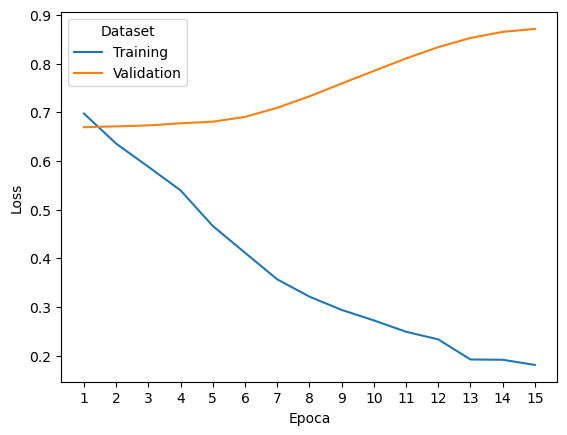

In [ ]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()